# MGT-6203

# Team-48

# Analysis of Mobile Data 2019

In [1]:
# Install packages if missing
packages <- c("ggplot2", "corrplot", "car", "MASS", "dplyr", "lubridate","randomForest","xgboost", "caret", "stats")
install.packages(setdiff(packages, rownames(installed.packages()))) 

In [2]:
# Load library
library(ggplot2)
library(corrplot)
library(car)
library(MASS)
library(dplyr)
library(lubridate)
library(caret)
library(glmnet)
library(randomForest)
library(xgboost)
library(Matrix)
library(stats)

corrplot 0.92 loaded

Loading required package: carData


Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:car':

    recode


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: timechange


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-6

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin



Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




### Step 1: Loading Datasets

In [3]:
# get current directory and reference to it
setwd("..")
getwd()

[1] "/Users/virginiasahagun/Documents/GitHub/Team-48"

In [4]:
flipkart_2019 <- read.csv('Data/Flipkart_Mobiles_2019.csv')
head(flipkart_2019, 3)

,Brand,Model,Color,Memory,Storage,Rating,Selling.Price,Original.Price
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>
1,OPPO,A53,Moonlight Black,4 GB,64 GB,4.5,11990,15990
2,OPPO,A53,Mint Cream,4 GB,64 GB,4.5,11990,15990
3,OPPO,A53,Moonlight Black,6 GB,128 GB,4.3,13990,17990


In [5]:
gadgets360_2019<-read.csv('Data/ndtv_data_final_2019.csv')
head(gadgets360_2019, 3)

,X,Name,Brand,Model,Battery.capacity..mAh.,Screen.size..inches.,Touchscreen,Resolution.x,Resolution.y,Processor,...,Rear.camera,Front.camera,Operating.system,Wi.Fi,Bluetooth,GPS,Number.of.SIMs,X3G,X4G..LTE,Price
,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
1,0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,...,48,16,Android,Yes,Yes,Yes,2,Yes,Yes,58998
2,1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,...,64,16,Android,Yes,Yes,Yes,2,Yes,Yes,27999
3,2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,...,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes,106900


### Step 2: Data Pre-processing

#### FlipKart Data

In [6]:
dim(flipkart_2019)
paste0('Initial Number of rows ', nrow(flipkart_2019))

[1] 3114    8

[1] "Initial Number of rows 3114"

In [7]:
# Remove Useless Columns
flipkart_2019$Memory<-NULL
flipkart_2019$Storage<-NULL
flipkart_2019$Original.Price<-NULL

In [8]:
# Number of rows with missing Values
flipkart_missing <- nrow(flipkart_2019) - nrow(flipkart_2019[complete.cases(flipkart_2019), ])
paste0('Number of rows with missing values ', flipkart_missing)
# Drop rows with missing values
flipkart_2019 <- flipkart_2019[complete.cases(flipkart_2019), ]
paste0('Cleaned Number of Rows  ', nrow(flipkart_2019))

[1] "Number of rows with missing values 144"

[1] "Cleaned Number of Rows  2970"

In [9]:
# remove duplicates
flipkart_2019 <-flipkart_2019[order(flipkart_2019[, "Selling.Price"], decreasing=TRUE),]
flipkart_2019 <- flipkart_2019[!duplicated(flipkart_2019[c("Brand", "Model", "Rating")]), ]
paste0('Final Number of Rows ', nrow(flipkart_2019))

[1] "Final Number of Rows 1079"

#### Gadgets360

In [10]:
gadgets360_missing <- nrow(gadgets360_2019) - nrow(gadgets360_2019[complete.cases(gadgets360_2019), ])
paste0('Number of rows with missing values ', gadgets360_missing)
# Drop rows with missing values
gadgets360_2019 <- gadgets360_2019[complete.cases(gadgets360_2019), ]
paste0('Cleaned Number of Rows  ', nrow(gadgets360_2019))

[1] "Number of rows with missing values 0"

[1] "Cleaned Number of Rows  1359"

In [11]:
# Remove Useless Columns
gadgets360_2019$Price<-NULL
gadgets360_2019$X<-NULL

In [12]:
# remove duplicates
gadgets360_2019 <- gadgets360_2019[!duplicated(gadgets360_2019[c("Brand", "Model")]), ]
paste0('Final Number of Rows ', nrow(gadgets360_2019))

[1] "Final Number of Rows 1359"

### Step 3: Merging Datasets

In [13]:
# Prepare for merging (Upper case and remove white spaces)
# Flipkart
flipkart_2019$Model = toupper(flipkart_2019$Model)
flipkart_2019$Brand = toupper(flipkart_2019$Brand)
flipkart_2019$Model <- trimws(flipkart_2019$Model, which = c("both"))
flipkart_2019$Brand <- trimws(flipkart_2019$Brand, which = c("both"))
# Gadgets360
gadgets360_2019$Model = toupper(gadgets360_2019$Model)
gadgets360_2019$Brand = toupper(gadgets360_2019$Brand)
gadgets360_2019$Model <- trimws(gadgets360_2019$Model, which = c("both"))
gadgets360_2019$Brand <- trimws(gadgets360_2019$Brand, which = c("both"))

In [14]:
# Merge Datasets
merged_df <- merge(flipkart_2019, gadgets360_2019, by.y=c("Brand","Model"), by.x=c("Brand","Model"), all=FALSE)
head(merged_df, 3)

,Brand,Model,Color,Rating,Selling.Price,Name,Battery.capacity..mAh.,Screen.size..inches.,Touchscreen,Resolution.x,...,Internal.storage..GB.,Rear.camera,Front.camera,Operating.system,Wi.Fi,Bluetooth,GPS,Number.of.SIMs,X3G,X4G..LTE
,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<int>,<dbl>,<chr>,<int>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
1,APPLE,IPHONE 11,Yellow,4.6,64900,iPhone 11,3110,6.1,Yes,828,...,64,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes
2,APPLE,IPHONE 11 PRO,Midnight Green,4.6,140300,iPhone 11 Pro,3046,5.8,Yes,1125,...,64,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes
3,APPLE,IPHONE 11 PRO MAX,Midnight Green,4.7,150800,iPhone 11 Pro Max,3969,6.5,Yes,1242,...,64,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes


In [15]:
paste0('Final Number of Rows ', nrow(merged_df))
dim(merged_df)

[1] "Final Number of Rows 387"

[1] 387  23

### Step 3: Final Dataset Pre-processing

In [16]:
# Since we are only looking into smartphones, we are going to drop any phones that do not have touchscreen
table(merged_df$Touchscreen)
merged_df <- merged_df[merged_df$Touchscreen == "Yes", ]


 No Yes 
  2 385 

In [17]:
# We are also going to focus only in phones that have 4G as we are focusing on the latest phones
table(merged_df$X4G..LTE)
merged_df <- merged_df[merged_df$X4G..LTE == "Yes", ]


 No Yes 
 61 324 

In [18]:
# laslty,after filtering everything, We are also going to drop 3g, 4g, touchscreen, bluetooth, wifi and gps columns
merged_df$X3G<-NULL
merged_df$Wi.Fi<-NULL
merged_df$Bluetooth<-NULL
merged_df$GPS<-NULL
merged_df$X4G..LTE<-NULL
merged_df$Touchscreen<-NULL

# Copy to Final Dataframe
final_df<-merged_df

In [19]:
# Factor columns
final_df$Brand <- as.factor(final_df$Brand)
final_df$Operating.system <- as.factor(final_df$Operating.system)
final_df$Model <- as.factor(final_df$Model)

In [20]:
# convert Resolution to product of X & Y resolution
final_df$Resolution <- final_df$Resolution.x * final_df$Resolution.y
final_df$Resolution.x <- NULL
final_df$Resolution.y <- NULL

In [21]:
summary(final_df)

     Brand                  Model        Color               Rating     
 SAMSUNG: 65   REDMI NOTE 6 PRO:  4   Length:324         Min.   :2.300  
 XIAOMI : 57   REDMI NOTE 7    :  4   Class :character   1st Qu.:4.100  
 LENOVO : 31   REDMI NOTE 7 PRO:  4   Mode  :character   Median :4.300  
 OPPO   : 28   1               :  3                      Mean   :4.218  
 NOKIA  : 21   2               :  3                      3rd Qu.:4.400  
 APPLE  : 19   3               :  3                      Max.   :5.000  
 (Other):103   (Other)         :303                                     
 Selling.Price        Name           Battery.capacity..mAh.
 Min.   :  4599   Length:324         Min.   :1050          
 1st Qu.: 10487   Class :character   1st Qu.:3000          
 Median : 14999   Mode  :character   Median :3500          
 Mean   : 23173                      Mean   :3553          
 3rd Qu.: 23099                      3rd Qu.:4000          
 Max.   :150800                      Max.   :6000       

### Step 4: Exploratory Data Analysis

#### Evaluate Correlation coefficients (Numeric Variables)

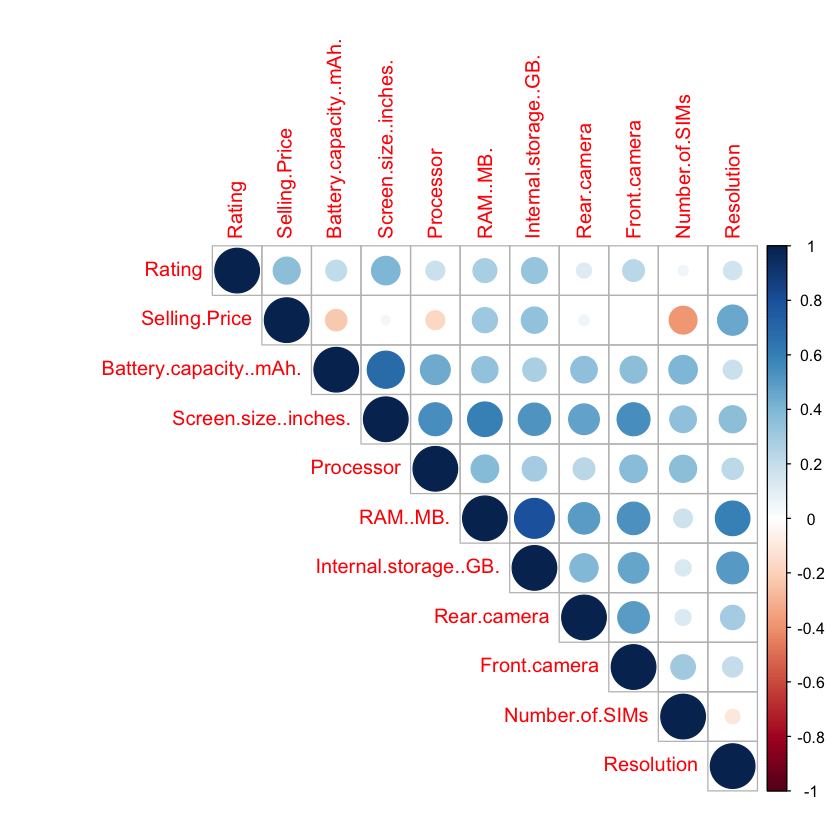

In [22]:
# define non-numeric variables
num_var <- names(final_df)[sapply(final_df, is.numeric)]
num_final_df <- final_df[, (names(final_df) %in% num_var)]  
# calculate correlation matrix
corr_matrix <- cor(num_final_df)
# Plot the correlation matrix
corrplot(corr_matrix, method="circle", type="upper")

#### Variance Inflation Factor (VIF)

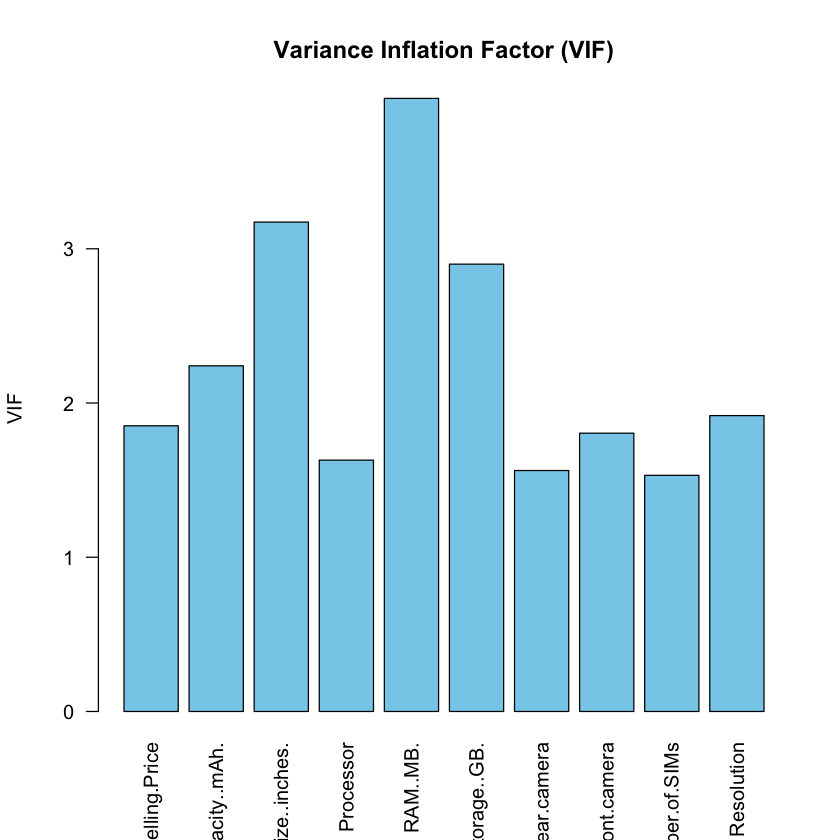

In [23]:
# build basic model
vif_lm <- lm(Rating~., data=num_final_df)
# Calculate and Plot VIF
vif_values <- vif(vif_lm)
barplot(vif_values, main = "Variance Inflation Factor (VIF)",  ylab = "VIF", col = "skyblue", las = 2)

#### Factor Variables

In [24]:
# Brand value distribution
table(final_df$Brand)


   APPLE     ASUS   GIONEE      HTC  INFINIX   LENOVO       LG MOTOROLA 
      19       11       16        8       14       31       19        3 
   NOKIA     OPPO     POCO   REALME  SAMSUNG     VIVO   XIAOMI 
      21       28        2       17       65       13       57 

#### Check distribution of Y variable

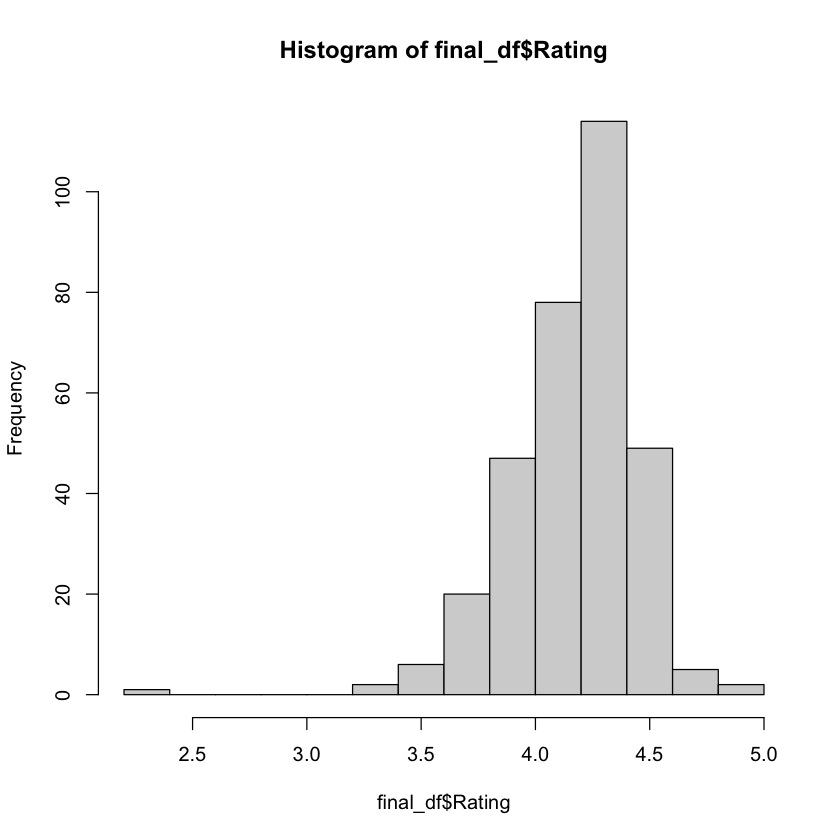

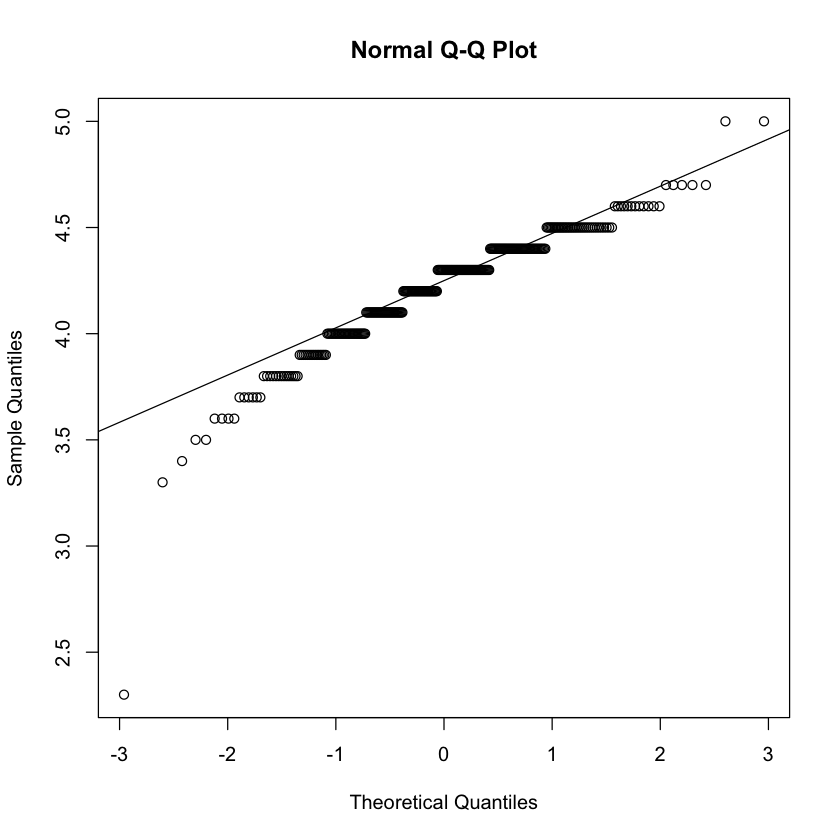

In [25]:
hist(final_df$Rating)
# QQplot of Y-Variable
qqnorm(final_df$Rating)
qqline(final_df$Rating)

#### Remove Outliers

In [26]:
filter(final_df, Rating < 3)

Brand,Model,Color,Rating,Selling.Price,Name,Battery.capacity..mAh.,Screen.size..inches.,Processor,RAM..MB.,Internal.storage..GB.,Rear.camera,Front.camera,Operating.system,Number.of.SIMs,Resolution
<fct>,<fct>,<chr>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>
XIAOMI,REDMI NOTE 8,Space Black,2.3,11999,Redmi Note 8,4000,6.3,8,3000,32,48,13,Android,2,2462400


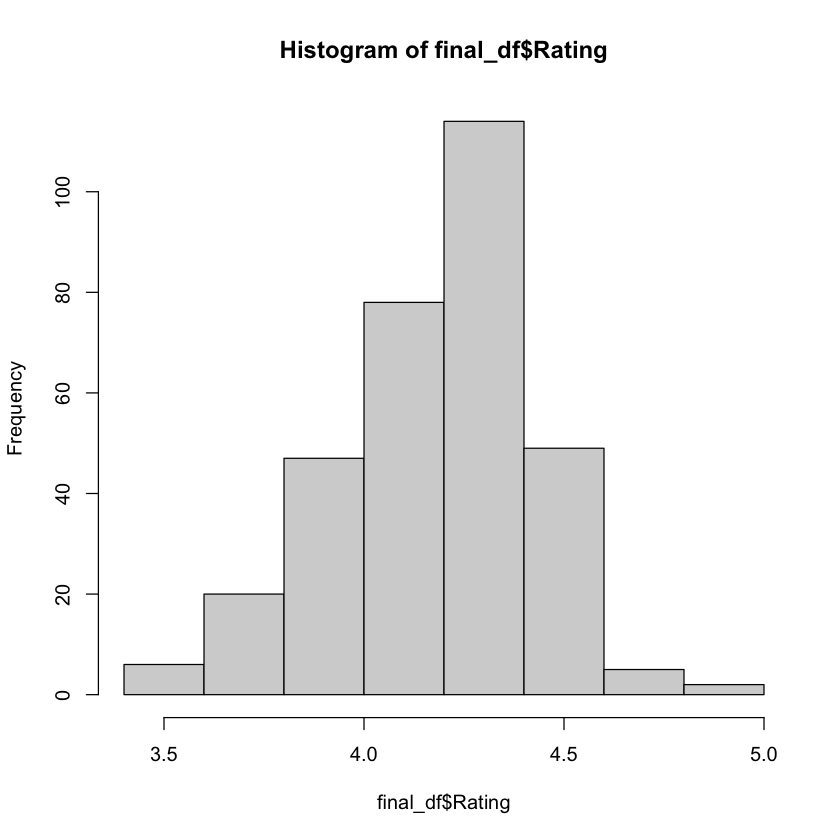

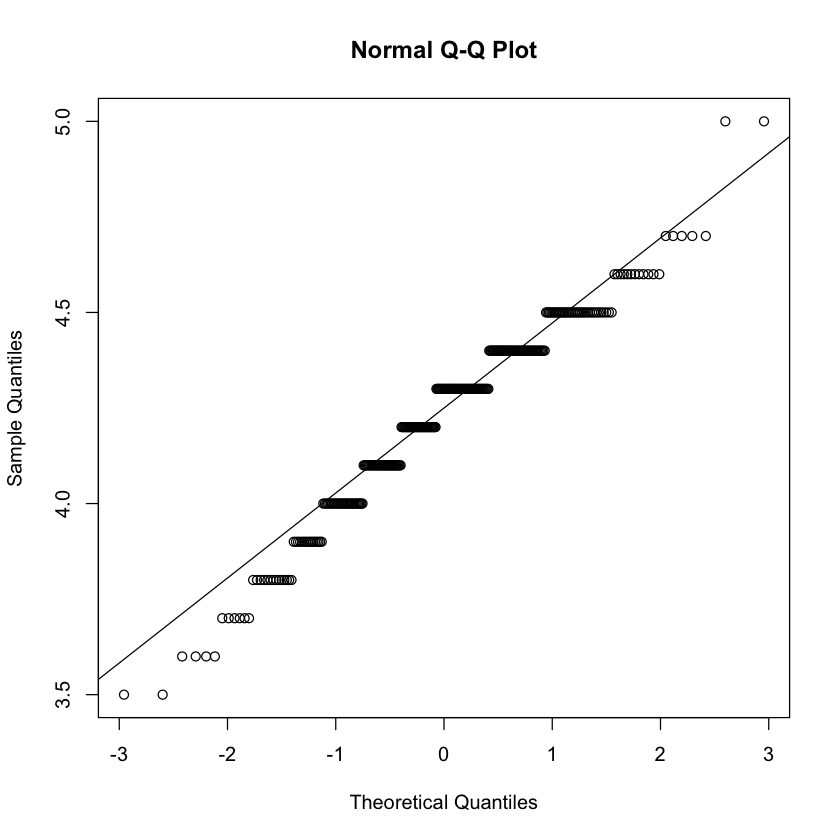

In [27]:
# filter to rating >= 3
final_df <- filter(final_df, Rating >= 3.5)
hist(final_df$Rating)
# QQplot of Y-Variable
qqnorm(final_df$Rating)
qqline(final_df$Rating)

### Step 5: Model preparation

In [28]:
# remove useless columns
final_df$Model<-NULL
final_df$Color<-NULL
final_df$Name<-NULL
final_df$Operating.system<-NULL

In [29]:
#Remove brands with <= phone
lm_df <- subset(final_df, final_df$Brand !='POCO', )
head(lm_df, 3)

,Brand,Rating,Selling.Price,Battery.capacity..mAh.,Screen.size..inches.,Processor,RAM..MB.,Internal.storage..GB.,Rear.camera,Front.camera,Number.of.SIMs,Resolution
,<fct>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,APPLE,4.6,64900,3110,6.1,6,4000,64,12,12,2,1483776
2,APPLE,4.6,140300,3046,5.8,6,4000,64,12,12,2,2740500
3,APPLE,4.7,150800,3969,6.5,6,4000,64,12,12,2,3338496


#### Split Data for Training and Testing

In [30]:
set.seed(1)
#split into train and test
trainIndex <- createDataPartition(lm_df$Rating, p = 0.7, list = FALSE)
train <- lm_df[trainIndex,]
test <- lm_df[-trainIndex,]

#### Use Cook's Distance to Identify Outliers

In [31]:
temp_model <- lm(Rating ~ ., data = train)
#Use Cook's Distance
train$cooks <-cooks.distance(temp_model)
# remove the outlier
train <- filter(train, cooks < 1)
train$cooks <- NULL

#### Calculate Leverage points

In [32]:
temp_model <- lm(Rating ~ ., data = train)
train$leverage <- hatvalues(temp_model)
# remove the outlier
train <- filter(train, leverage < 1)
train$leverage <- NULL

### Step 6: Modelling

#### Linear Regression 

In [41]:
#Train model
lm_model <- lm(Rating ~ ., data = train)
#Predict test data
predictions0 <- predict(lm_model, newdata = test)
#Model summary
summary(lm_model)


Call:
lm(formula = Rating ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49185 -0.07796  0.01514  0.09194  0.51300 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.178e+00  2.073e-01  20.155  < 2e-16 ***
BrandASUS              -5.852e-01  1.155e-01  -5.068 9.08e-07 ***
BrandGIONEE            -6.969e-01  1.208e-01  -5.770 2.97e-08 ***
BrandHTC               -5.413e-01  1.141e-01  -4.745 3.95e-06 ***
BrandINFINIX           -4.752e-01  1.288e-01  -3.690 0.000288 ***
BrandLENOVO            -6.288e-01  1.128e-01  -5.576 7.86e-08 ***
BrandLG                -5.667e-01  1.084e-01  -5.229 4.26e-07 ***
BrandMOTOROLA          -4.865e-01  1.640e-01  -2.966 0.003380 ** 
BrandNOKIA             -5.483e-01  1.092e-01  -5.023 1.12e-06 ***
BrandOPPO              -3.497e-01  1.082e-01  -3.231 0.001443 ** 
BrandREALME            -2.372e-01  1.166e-01  -2.034 0.043253 *  
BrandSAMSUNG           -4.200e-01  9.918e-0

In [42]:
#Train model
final_model <- lm(Rating ~ Brand+Battery.capacity..mAh.+Internal.storage..GB., data = train)
#Predict test data
predictions <- predict(final_model, newdata = test)
#Model summary
summary(final_model)


Call:
lm(formula = Rating ~ Brand + Battery.capacity..mAh. + Internal.storage..GB., 
    data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52158 -0.08028  0.01500  0.09613  0.48918 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.352e+00  5.856e-02  74.320  < 2e-16 ***
BrandASUS              -6.236e-01  7.599e-02  -8.206 2.32e-14 ***
BrandGIONEE            -7.227e-01  6.962e-02 -10.382  < 2e-16 ***
BrandHTC               -5.421e-01  8.367e-02  -6.479 6.52e-10 ***
BrandINFINIX           -5.029e-01  8.101e-02  -6.208 2.85e-09 ***
BrandLENOVO            -6.463e-01  5.584e-02 -11.575  < 2e-16 ***
BrandLG                -5.972e-01  6.345e-02  -9.413  < 2e-16 ***
BrandMOTOROLA          -4.988e-01  1.236e-01  -4.037 7.61e-05 ***
BrandNOKIA             -5.728e-01  5.726e-02 -10.003  < 2e-16 ***
BrandOPPO              -3.761e-01  5.594e-02  -6.724 1.65e-10 ***
BrandREALME            -2.725e-01  6.736e-02  -4.04

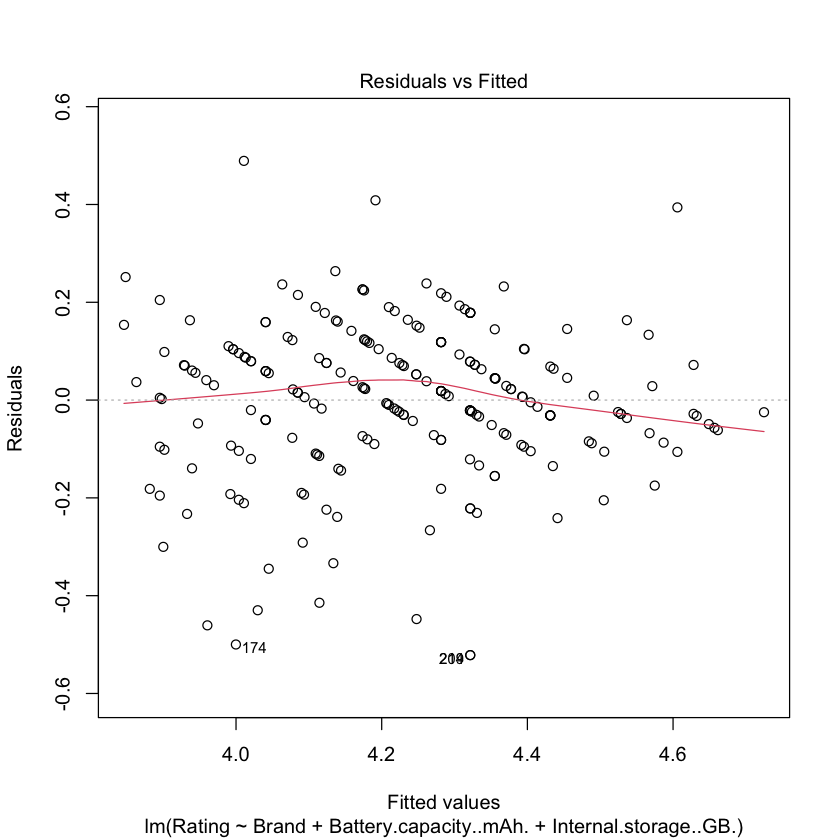

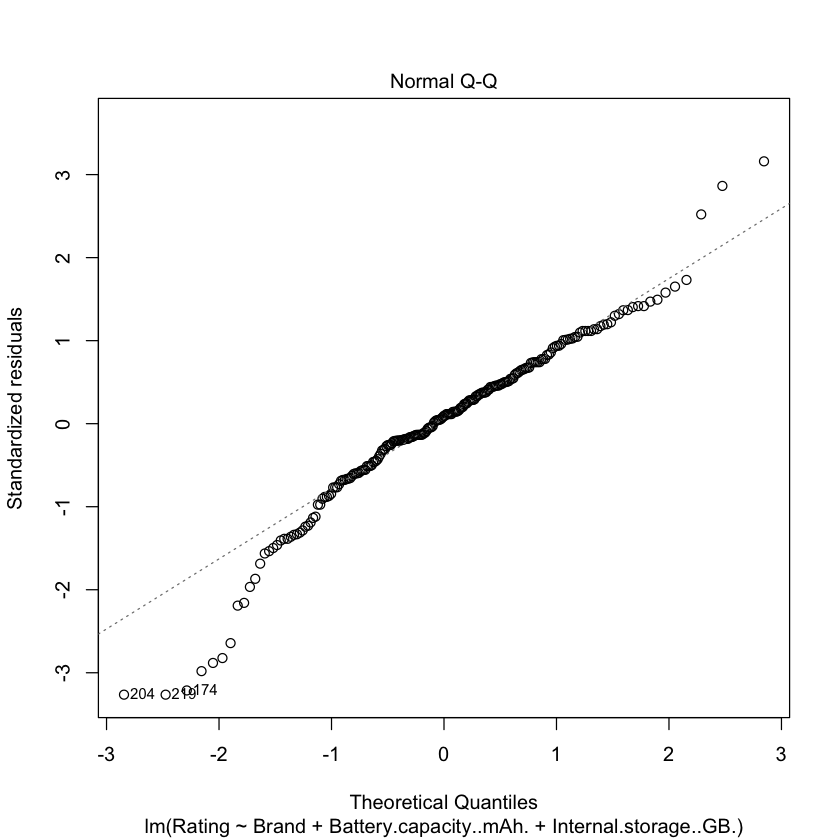

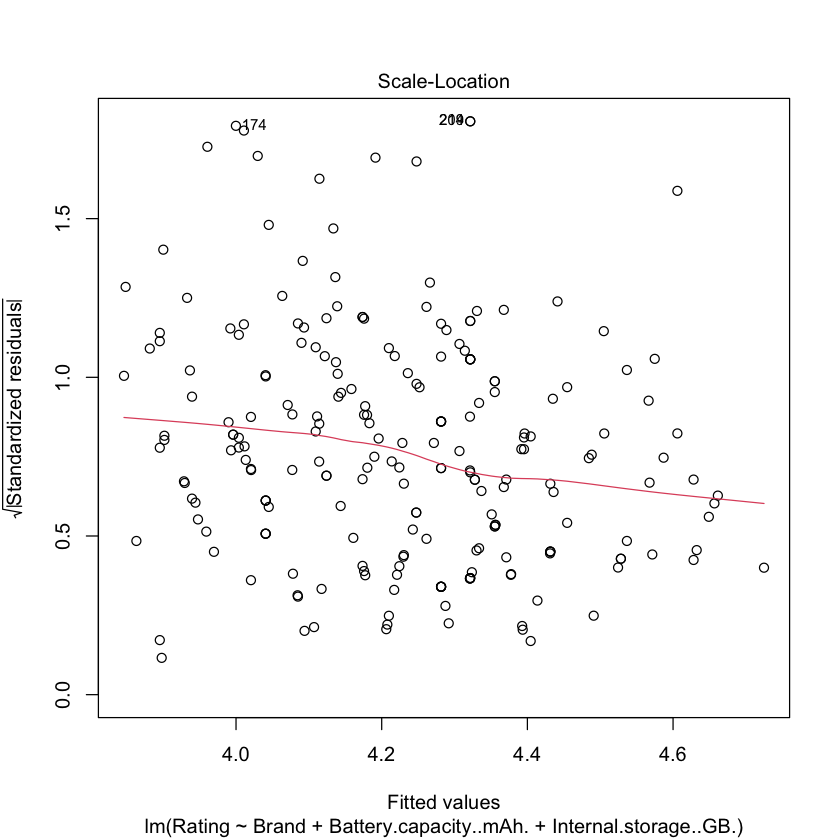

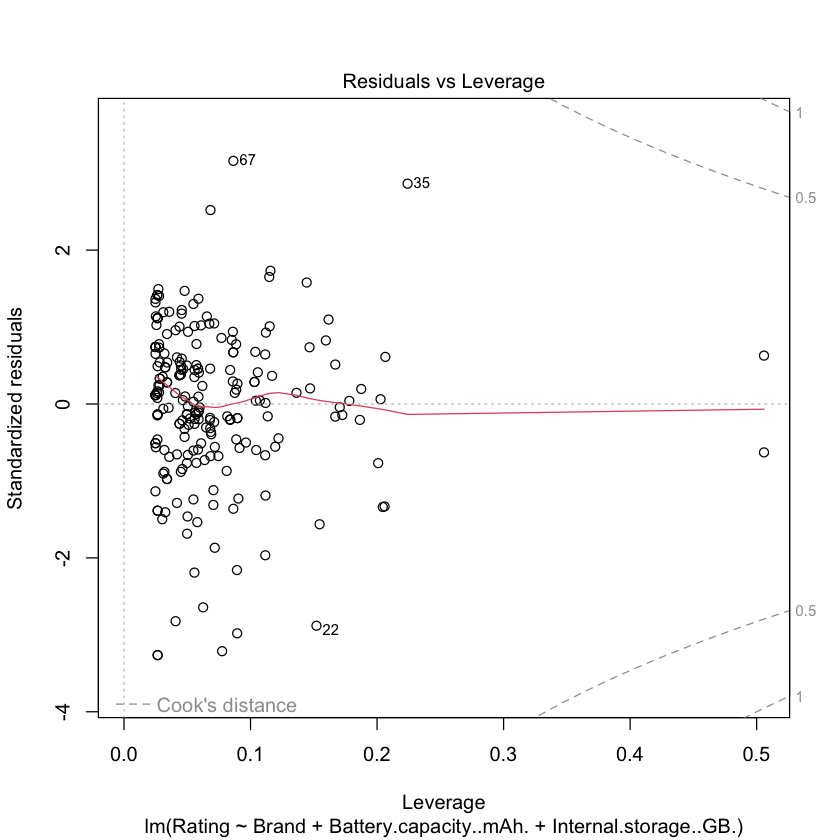

In [43]:
plot(final_model)

In [44]:
#Calculate mean-squared error
linear_regression_mse <- mean((test$Rating - predictions)^2)
linear_regression_rmse <- sqrt(linear_regression_mse)
#R-Squared
lm_r_squared <- summary(final_model)$adj.r.squared

#### Random Forest

In [45]:
# Train random forest regression model 
random_forest_model <- randomForest(Rating ~ ., data = train, ntree = 1000)
# Make predictions on the test set using the predict() function
predictions <- predict(random_forest_model, newdata = test)

In [46]:
# Calculate mean squared error (MSE)
random_forest_mse <- mean((test$Rating - predictions)^2)
random_forest_rmse <- sqrt(random_forest_mse)

In [52]:
#R-squared
rf_rsquared <- R2(predictions, test$Rating)
rf_rsquared

[1] 0.5609661

In [53]:
importance(random_forest_model)

,IncNodePurity
Brand,4.0155168
Selling.Price,2.3958917
Battery.capacity..mAh.,1.1694565
Screen.size..inches.,1.4405390
Processor,0.3440878
RAM..MB.,0.3738188
Internal.storage..GB.,0.5666088
Rear.camera,0.4378864
Front.camera,0.4816680
Number.of.SIMs,0.1854911


#### XGBoost

[18:48:19] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


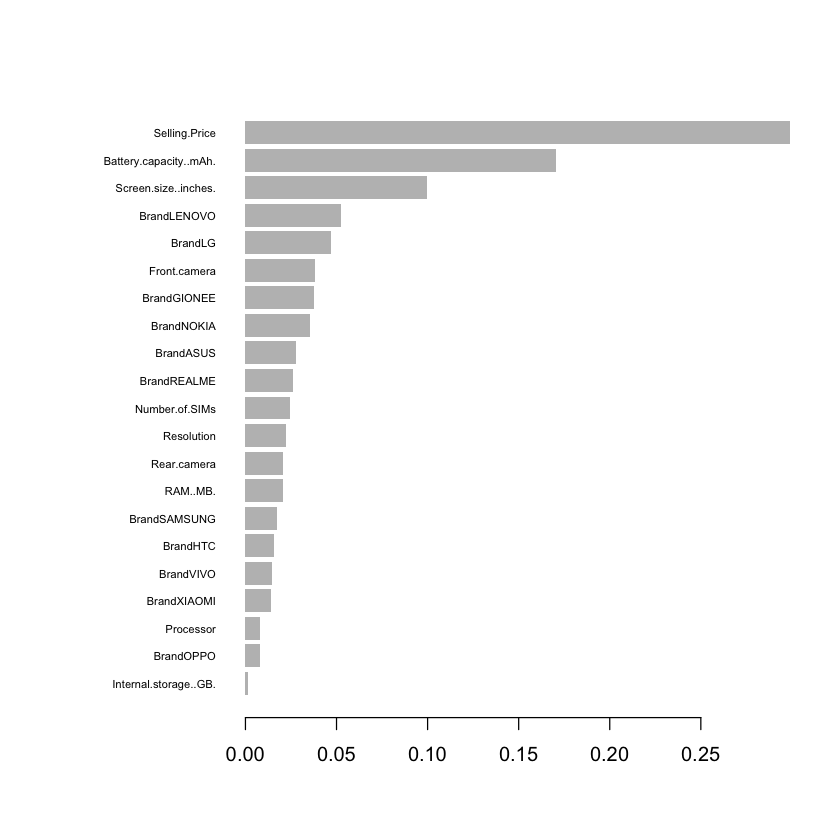

In [54]:
train_mtx <- sparse.model.matrix(Rating ~ ., data = train)
test_mtx <- sparse.model.matrix(Rating ~ ., data = test)

dtrain <- xgb.DMatrix(data = train_mtx, label = train$Rating)
dtest <- xgb.DMatrix(data =test_mtx,label=test$Rating)

# train XGBoost model
xgb_model <- xgboost(data = dtrain, max_depth = 3, eta = 0.1, nrounds = 100, objective = "reg:linear", verbose = 0)

# get feature importance
xgb_importance <- xgb.importance(attr(train_mtx, "dimnames")[[2]], model = xgb_model)

# plot feature importance
xgb.plot.importance(xgb_importance)

In [55]:
# Make predictions on the test set using the predict() function
predictions <- predict(xgb_model, newdata = test_mtx)
# Calculate mean squared error (MSE)
xgboost_mse <- mean((test$Rating - predictions)^2)
xgboost_rmse <- sqrt(xgboost_mse)
#R-squared
xgboost_rsquared <- R2(predictions, test$Rating)
xgboost_rsquared

[1] 0.5609661

### Step 7: Models Comparison

In [56]:
#Model Comparison Table
table <- matrix(c(lm_r_squared , linear_regression_mse, linear_regression_rmse, 
                  rf_rsquared, random_forest_mse, random_forest_rmse,
                  xgboost_rsquared, xgboost_mse, xgboost_rmse),
                ncol=3)

#specify row and column names of matrix
rownames(table) <- c('R-Squared', 'MSE', 'RMSE')

colnames(table) <- c('Linear Regression', 'Random Forest', 'XGBoost')

#convert matrix to table
table <- as.table(table)
table

          Linear Regression Random Forest    XGBoost
R-Squared        0.57292243    0.56096607 0.56096607
MSE              0.02679565    0.02345574 0.02638037
RMSE             0.16369376    0.15315266 0.16242035